In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.wcs import WCS
from matplotlib.lines import Line2D

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

Traceback (most recent call last):
  File "/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/vaex/scopes.py", line 236, in __getitem__
    raise KeyError("Unknown variables or column: %r" % (variable,))
KeyError: "Unknown variables or column: 'OPT_GST'"
ERROR:ThreadPoolExecutor-1_7:vaex.scopes:error in evaluating: 'OPT_GST'
Traceback (most recent call last):
  File "/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/vaex/scopes.py", line 236, in __getitem__
    raise KeyError("Unknown variables or column: %r" % (variable,))
KeyError: "Unknown variables or column: 'OPT_GST'"
  File "/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/threading.py", line 870, in run

error name 'OPT_GST' is not defined
error name 'OPT_GST' is not defined
error name 'OPT_GST' is not defined


NameError: name 'OPT_GST' is not defined

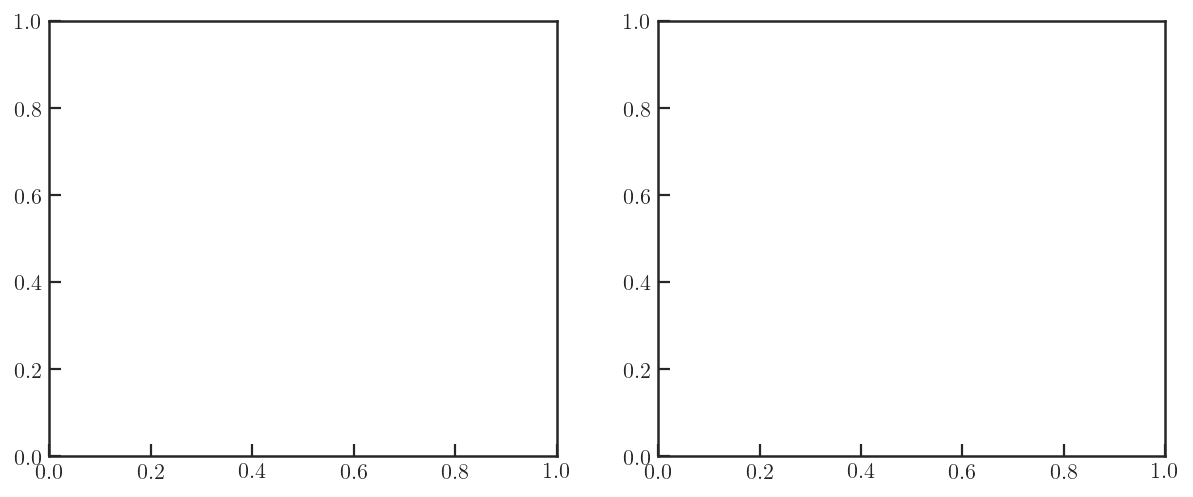

In [15]:
w = WCS(fits.Header.fromtextfile('../M33_B01_NW/M33_B01_NW_F475W_drc_wcs.txt'))
ds = vaex.read_csv('../ast_inputs/M33_B01_NW_inputAST.txt', delim_whitespace=True)
ra, dec = w.all_pix2world(*ds.evaluate(['X','Y']), 0.5)
ds.add_column
ds2 = vaex.open('../m33_merged/M33_B01_NW.hdf5')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
kwargs = dict(colorbar=False, f='log10', vmin=0, vmax=3, shape=100, limits=[[8500,12500],[10000,14000]])
plt.sca(ax1)
ds2.plot('X','Y', selection='F475W_SNR > 4', **kwargs)
plt.sca(ax2)
ds.plot('X','Y', **kwargs)


38040

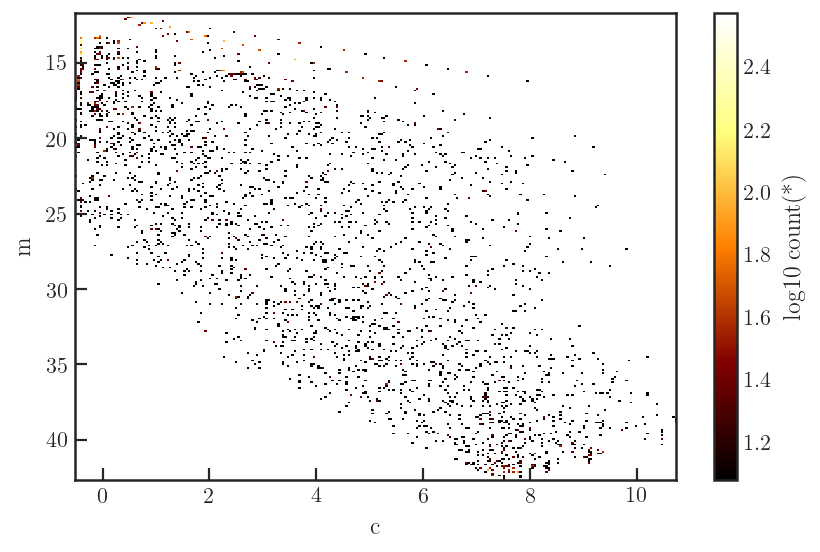

In [16]:
ds.plot('HST_WFC3_F475W-HST_WFC3_F814W', 'HST_WFC3_F814W', f='log10', xlabel='c', ylabel='m',
        limits='minmax')
plt.gca().invert_yaxis()
ds.length()

In [10]:
for c in ds.get_column_names():
    print(ds.minmax(c))

[0 0]
[1 1]
[ 5806.13332 12502.92958]
[ 8207.01991 13964.09649]
[11.92883 50.73453]
[10.32246 51.58485]
[10.91514 53.32271]
[11.72312 42.66267]
[11.6852  39.22701]
[11.64968 37.00017]
[    0 38039]
